In [44]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


# FDTD Library is open source MEEP
# https://meep.readthedocs.io/en/latest/

import meep as mp
#from meep.materials import SiO2, Si

%matplotlib widget

### Simulation Settings

In [45]:

# To understand MEEP units see https://meep.readthedocs.io/en/latest/Introduction/#units-in-meep
wavelength = 1.55 # wavelength can have arbitrary length units (we choose um)
f = 1/wavelength # Frequency is defined in "natural units" as (1 um)/wavelength

l,w,z = [100,75,0] # length,width,height of the simulation region (um)
r = 30 # Star Coupler Radius (um)
h = 25 # Star Coupler Height (um) (this gives the flat top/bottom if desired)

waveguide_width = 0.5 # width of Si waveguide (um)
nguides_p = 10 # number of input waveguides above center (total numper is 2*nguides_p+1)
nangles = np.arange(-nguides_p,nguides_p+1,1) 

amplitudes = np.ones(len(nangles),dtype=complex) # amplitude/phase shift for each sources

## For tilted input
# amplitudes = np.zeros(len(nangles),dtype=complex) # amplitude/phase shift for each sources
# dl = 2*np.pi/len(nangles)
# for n in range(len(nangles)):
#     amplitudes[n]=np.exp(-1j*n)


y_guide_size = 1 # width of eigenmode source (needs to enclose waveguide)
dr = 10 # srces are placed at distance r+dr from confocal point

neff = 2.44 # Effective slab index from Lumerical simulation
#neff = 2.85

res = 30 # sim resolution (pixels/um)

### Create simulation region and define media

In [46]:
# Define Simulation Cell
# All length units are microns
cell = mp.Vector3(l,w,z)

si = mp.Medium(epsilon=12)
sio2 = mp.Medium(index=1.444)

### Create Starcoupler Region as MP Material Grid

In [47]:
x = np.arange(-r,r,1/res)
y = np.arange(-1.5*h/2,1.5*h/2,1/res)
xx,yy = np.meshgrid(x,y)

c1 = ((xx-r/2)**2 + yy**2 < r**2) # First circle with radius r
c2 = ((xx+r/2)**2 + yy**2 < r**2) # Second circle with radius r
b = (yy<h/2) & (yy>-h/2) # Rectangle allowing top/bottom cutoff

sc = c1 & c2 & b # star coupler shape comes from logical-AND all 3 shapes

star_grid = mp.MaterialGrid([len(x),len(y),0],
                           medium1 = sio2,
                           medium2 = si,
                           weights = sc.transpose())

star_block = mp.Block(size=mp.Vector3(x[-1]-x[0],y[-1]-y[0],0),material=star_grid)


### Create Input and Output Waveguides

In [48]:
rot_angles = [np.arcsin(i*np.sqrt((1.55)/(r*len(nangles)*neff))) for i in nangles]

def make_waveguide(th,l,r):
    wg = mp.Block(mp.Vector3(np.abs(l),waveguide_width,mp.inf),
                     center=mp.Vector3(0,0),
                     e1=mp.Vector3(x=1).rotate(mp.Vector3(z=1), th),
                     e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), th),
                     material=si)
    
    wg = wg.shift(mp.Vector3(x=r/2-l*np.cos(th)/2,y=-l*np.sin(th)/2))
    return wg

input_waveguides = [make_waveguide(th,l,r) for th in rot_angles]
output_waveguides = [make_waveguide(th,-l,-r) for th in rot_angles]

### Add Eigenmode Sources

In [49]:

def wg_eig_src(r,dr,th,ysize=1,freq=f,bd=1,amp=1.0):
    eig_src = mp.EigenModeSource(src=mp.ContinuousSource(frequency=freq),
                                 size=mp.Vector3(y=ysize),
                                 direction=mp.NO_DIRECTION,
                                 eig_kpoint=mp.Vector3(x=1).rotate(mp.Vector3(z=1),-th),
                                 center=mp.Vector3(-(r+dr)*np.cos(th)+r/2,(r+dr)*np.sin(th),0),
                                 eig_band = bd,
                                 eig_parity=mp.ODD_Z,
                                 eig_match_freq=True,
                                 amplitude=amp)
    return eig_src

# Adds an eigenmode source for each input waveguide -- can get a source's amplitude to 0 to turn it off
# bottom 1/2
# sources = [wg_eig_src(r,dr,s,ysize=y_guide_size,amp=a) for (s,a) in zip(rot_angles[0:int((len(rot_angles)-1)/2)],amplitudes[0:int((len(rot_angles)-1)/2)])]

# full
sources = [wg_eig_src(r,dr,s,ysize=y_guide_size,amp=a) for (s,a) in zip(rot_angles,amplitudes)]


### Create Simulation Object

In [50]:
sim = mp.Simulation(resolution = res,
                    cell_size = cell,
                    default_material=sio2,
                    geometry = [star_block] + output_waveguides + input_waveguides,
                    sources=sources,
                    boundary_layers=[mp.PML(2.0)],
                    symmetries=[])

### Add Mode Monitors

In [51]:


def create_monitor(r,dr,th,ysize=1):
    flux = sim.add_mode_monitor(f, 0, 1, 
                            mp.ModeRegion(mp.Vector3(-(r+dr)*np.cos(th)+r/2,(r+dr)*np.sin(th),0),size=mp.Vector3(y=ysize)), 
                            decimation_factor=0,
                            direction=mp.NO_DIRECTION,
                            eig_kpoint=mp.Vector3(x=1).rotate(mp.Vector3(z=1),-th))
    return flux


#  top half left side
# monitors = [create_monitor(r-1,dr,s,ysize=y_guide_size) for (s,a) in zip(rot_angles[int((len(rot_angles)-1)/2):len(rot_angles)],amplitudes[int((len(rot_angles)-1)/2):len(rot_angles)])]

# all left side
input_monitors = [create_monitor(r-1,dr,s,ysize=y_guide_size) for (s,a) in zip(rot_angles,amplitudes)]

output_monitors = [create_monitor(-r+1,-dr,s,ysize=y_guide_size) for (s,a) in zip(rot_angles,amplitudes)]

### Initialize Simulation

In [52]:
# Separating the initialization call from the run call allows the option of viewing the simulation geometry/index before running the simulation
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00337887 s
Working in 2D dimensions.
Computational cell is 100 x 75 x 0 with resolution 30
     block, center = (0,0,0)
          size (59.9667,37.4667,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (32.4122,-15.8771,0)
          size (100,0.5,1e+20)
          axes (0.948244,-0.317542,0), (0.317542,0.948244,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (32.9147,-14.2894,0)
          size (100,0.5,1e+20)
          axes (0.958293,-0.285787,0), (0.285787,0.958293,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.3598,-12.7017,0)
          size (100,0.5,1e+20)
          axes (0.967195,-0.254033,0), (0.254033,0.967195,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.7492,-11.114,0)
          size (100,0.5,1e+20)
          axes (0.974983,-0.222279,0), (0.222279,0.

### Run Simulation

In [53]:
sim.run(until=300)

FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 2.3666666666666667/300.0 = 0.8% done in 4.0s, 505.7s to go
on time step 142 (time=2.36667), 0.0282982 s/step
Meep progress: 4.816666666666666/300.0 = 1.6% done in 8.0s, 492.6s to go
on time step 289 (time=4.81667), 0.0273234 s/step
Meep progress: 7.366666666666666/300.0 = 2.5% done in 12.1s, 478.7s to go
on time step 442 (time=7.36667), 0.0262286 s/step
Meep progress: 9.866666666666667/300.0 = 3.3% done in 16.1s, 472.5s to go
on time step 592 (time=9.86667), 0.0267837 s/step
Meep progress: 12.45/300.0 = 4.1% done in 20.1s, 464.1s to go
on time step 747 (time=12.45), 0.0259573 s/step
Meep progress: 15.033333333333333/300.0 = 5.0% done in 24.1s, 457.2s to go
on time step 902 (time=15.0333), 0.0259665 s/step
Meep progress: 17.53333333333333/300.0 = 5.8% done in 28.1s, 453.3s to go
on time step 1052 (time=17.5333), 0.0267921 s/step
Meep progress: 20.116666666666667/300.0 = 6.7% done in 32.1s, 447.2s to go
on time step 1207 (time=20.1167), 0.0258296 s/step
Meep progress: 22.6

### Visualize E-field

     block, center = (0,0,0)
          size (59.9667,37.4667,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (32.4122,-15.8771,0)
          size (100,0.5,1e+20)
          axes (0.948244,-0.317542,0), (0.317542,0.948244,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (32.9147,-14.2894,0)
          size (100,0.5,1e+20)
          axes (0.958293,-0.285787,0), (0.285787,0.958293,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.3598,-12.7017,0)
          size (100,0.5,1e+20)
          axes (0.967195,-0.254033,0), (0.254033,0.967195,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (33.7492,-11.114,0)
          size (100,0.5,1e+20)
          axes (0.974983,-0.222279,0), (0.222279,0.974983,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (34.0841,-9.52625,0)
          size (100,0.5,1e+20)
          a

          axes (0.987315,-0.158771,0), (0.158771,0.987315,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (34.595,-6.35083,0)
          size (100,0.5,1e+20)
          axes (0.991901,-0.127017,0), (0.127017,0.991901,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (34.7726,-4.76312,0)
          size (100,0.5,1e+20)
          axes (0.995452,-0.0952625,0), (0.0952625,0.995452,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (34.8991,-3.17542,0)
          size (100,0.5,1e+20)
          axes (0.997981,-0.0635083,0), (0.0635083,0.997981,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     ...(+ 33 objects not shown)...


<Axes: xlabel='X', ylabel='Y'>

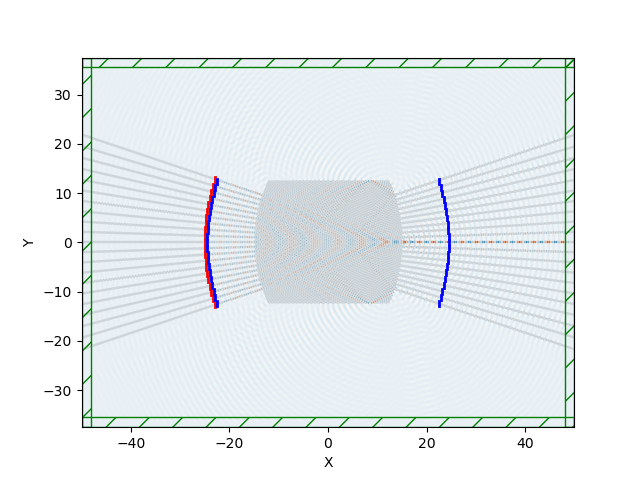

In [54]:
f1,ax1 = plt.subplots()

sim.plot2D(ax=ax1,output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(l,w,0)),
               fields=mp.Ez,
               field_parameters={'alpha':0.9})

In [55]:
print("Input Monitors:");
for i in range(len(input_monitors)):
     print(mp.get_fluxes(input_monitors[i]), " --> ", mp.get_fluxes(output_monitors[i]))



Input Monitors:
[14173.10559172337]  -->  [534.9109911691909]
[14205.833260727195]  -->  [206.81651744434694]
[14216.990320184961]  -->  [190.63350466078236]
[14253.78320161889]  -->  [108.95633376141299]
[14369.242859300677]  -->  [131.2739673701256]
[14427.82114137367]  -->  [157.66538544530948]
[9742.614087762051]  -->  [388.6206270890435]
[14391.862233817552]  -->  [389.01570020592857]
[12779.375317749284]  -->  [448.8030963985951]
[13994.83169096803]  -->  [1569.9221813356132]
[14395.194111955092]  -->  [20659.68784978963]
[13995.245758985784]  -->  [1576.696952418572]
[12777.43208738154]  -->  [476.8053699026094]
[14394.49694773848]  -->  [379.3380821252]
[9730.066495455438]  -->  [393.58760031282435]
[14429.292214744655]  -->  [181.90343906119554]
[14370.607705682958]  -->  [119.86784420946897]
[14256.445428908062]  -->  [113.54599583425055]
[14211.710539830894]  -->  [161.4008560607608]
[14211.00043625503]  -->  [216.9956257383826]
[14171.82664108313]  -->  [464.8993592685002]


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
[14173.10559172337, 14205.833260727195, 14216.990320184961, 14253.78320161889, 14369.242859300677, 14427.82114137367, 9742.614087762051, 14391.862233817552, 12779.375317749284, 13994.83169096803, 14395.194111955092, 13995.245758985784, 12777.43208738154, 14394.49694773848, 9730.066495455438, 14429.292214744655, 14370.607705682958, 14256.445428908062, 14211.710539830894, 14211.00043625503, 14171.82664108313]
[534.9109911691909, 206.81651744434694, 190.63350466078236, 108.95633376141299, 131.2739673701256, 157.66538544530948, 388.6206270890435, 389.01570020592857, 448.8030963985951, 1569.9221813356132, 20659.68784978963, 1576.696952418572, 476.8053699026094, 379.3380821252, 393.58760031282435, 181.90343906119554, 119.86784420946897, 113.54599583425055, 161.4008560607608, 216.9956257383826, 464.8993592685002]


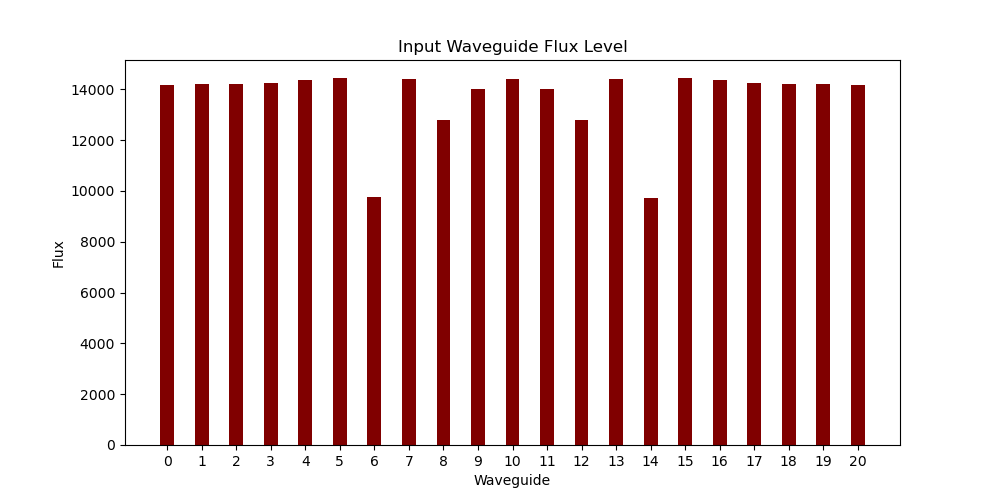

/var/folders/n9/t95q2lwd23ld2v_zyxd6w6jm0000gr/T/ipykernel_29119/2491122511.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (10, 5))


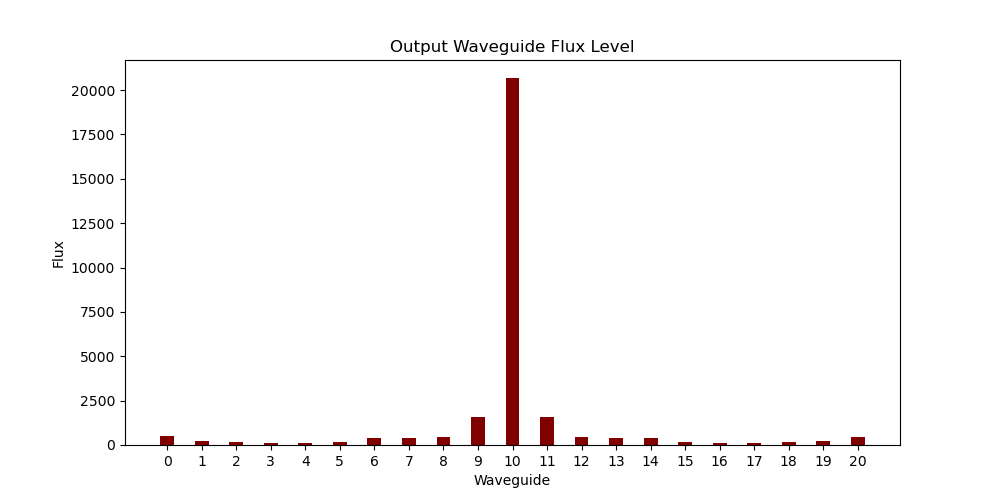

In [56]:
waveguides = []
for i in range(len(input_monitors)):
    waveguides.append(str(i))

input_flux = []
output_flux = []

for i in range(len(input_monitors)):
    input_flux.append(mp.get_fluxes(input_monitors[i])[0])
    output_flux.append(mp.get_fluxes(output_monitors[i])[0])

print(waveguides)
print(input_flux)
print(output_flux)
fig = plt.figure(figsize = (10, 5))

plt.bar(waveguides, input_flux, color="maroon", width = 0.4)

plt.title('Input Waveguide Flux Level')
plt.xlabel('Waveguide')
plt.ylabel('Flux')
plt.show()

fig = plt.figure(figsize = (10, 5))

plt.bar(waveguides, output_flux, color="maroon", width = 0.4)

plt.title('Output Waveguide Flux Level')
plt.xlabel('Waveguide')
plt.ylabel('Flux')
plt.show()

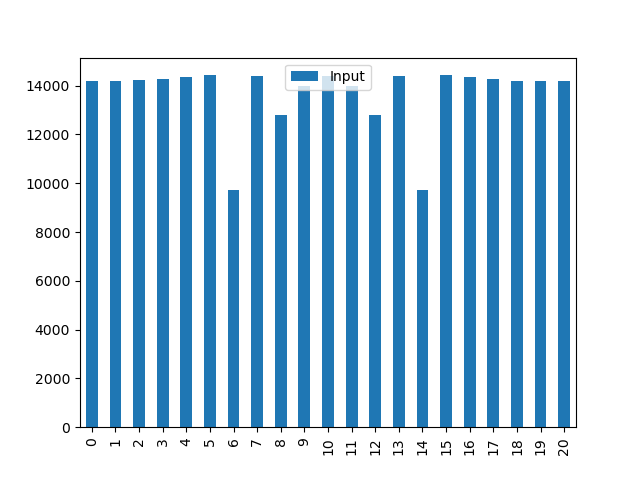

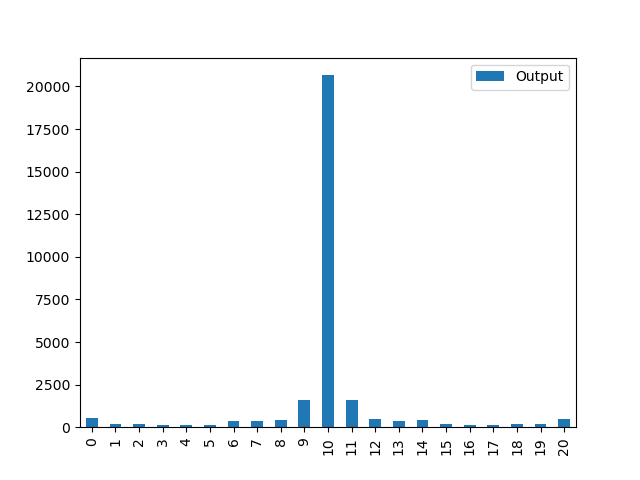

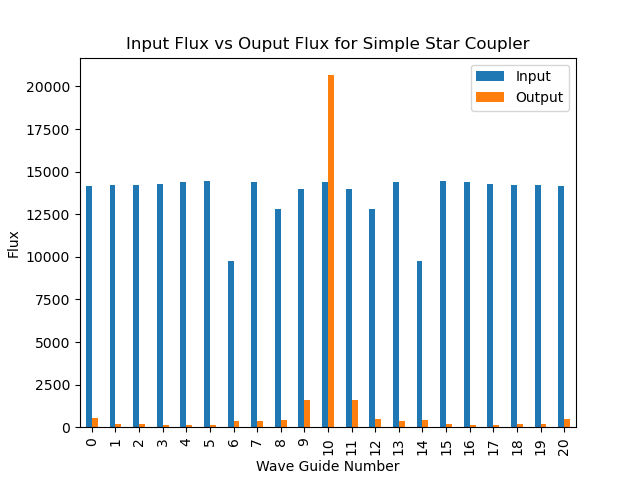

In [57]:
# Make a data definition
_data = {'Input': input_flux}
_df = pd.DataFrame(_data,columns=['Input'], index = waveguides)

# Multiple bar chart
_df.plot.bar()

# Display the plot
plt.show()


# Make a data definition
_data = {'Output': output_flux}
_df = pd.DataFrame(_data,columns=['Output'], index = waveguides)

# Multiple bar chart
_df.plot.bar()

# Display the plot
plt.show()

# Make a data definition
_data = {
    'Input': input_flux,
    'Output': output_flux
    }
_df = pd.DataFrame(_data,columns=['Input','Output'], index = waveguides)

# Multiple bar chart
_df.plot.bar()
plt.title("Input Flux vs Ouput Flux for Simple Star Coupler")
plt.xlabel("Wave Guide Number")
plt.ylabel("Flux")

# Display the plot
plt.show()